<a href="https://colab.research.google.com/github/PrasadRaoJammuna/test/blob/master/NB_AMZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,accuracy_score,roc_auc_score

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
#from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
from gensim.models import Word2Vec
from tqdm import tqdm


In [0]:
data = pd.read_csv('Reviews.csv', error_bad_lines=False)
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [0]:
data.shape

(568454, 10)

In [0]:
data=data[data['Score']!=3]
data.shape

(525814, 10)

In [0]:
def score_rate(score):
  if score >3:
    return 1
  else:
    return 0
  

In [0]:
score_rate(data['Score'][1])

0

In [0]:
data['Score'] = data['Score'].apply(score_rate)
data['Score'].head(5)

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

In [0]:
data.Score.value_counts(normalize=True)

1    0.843981
0    0.156019
Name: Score, dtype: float64

In [0]:
#Deduplication of entries
data=data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data.shape

(364173, 10)

In [0]:
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
data.shape

(364171, 10)

##  Preprocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-



1.   Remove any punctuations or limited set of special characters like , or . or # etc.
2. Begin by removing the html tags
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
8. After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = data['Text'].values[4900]
print(sent_4900)
print("="*50)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
This is not jerky, this is processed, hard like a rock, very greasy and stale smelling stripe of something that you can't break into anything smaller than 2 inches long and that certainly is not the size of a training treat! The dogs- 45lb dogs that will eat anything- were not impressed, it was hard to chew, and it sounded like they were crunching rocks, most of them spat it out after a few chews, left it there, this would be the first time they would not eat something in their entire lives, these dogs will work for lettuce. Where is a zero star button?
Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.
M

In [0]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Aboulutely love Popchips!I first tried these healthy chips at a marathon i did in California. I like this variety pack because i got to try alot of the flavors ive never had.


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df_pos = data[data['Score']==1].head(15000).sample(2450)
df_pos.shape

(2450, 10)

In [0]:
df_neg = data[data['Score']==0].tail(20000).sample(2670)
df_neg.shape

(2670, 10)

In [0]:
df = pd.concat([df_neg,df_pos])
df.shape

(5120, 10)

In [0]:
df.Score.value_counts(normalize=True)

0    0.521484
1    0.478516
Name: Score, dtype: float64

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 5120/5120 [00:02<00:00, 2451.76it/s]


In [0]:
l=[]
for e in sent_1000.split():
  if e.lower() not in stopwords:
    l.append(''.join(e.strip()))
print(l)

['not', 'jerky,', 'processed,', 'hard', 'like', 'rock,', 'greasy', 'stale', 'smelling', 'stripe', 'something', "can't", 'break', 'anything', 'smaller', '2', 'inches', 'long', 'certainly', 'not', 'size', 'training', 'treat!', 'dogs-', '45lb', 'dogs', 'eat', 'anything-', 'not', 'impressed,', 'hard', 'chew,', 'sounded', 'like', 'crunching', 'rocks,', 'spat', 'chews,', 'left', 'there,', 'would', 'first', 'time', 'would', 'not', 'eat', 'something', 'entire', 'lives,', 'dogs', 'work', 'lettuce.', 'zero', 'star', 'button?']


In [0]:
len(preprocessed_reviews)

5120

# BOW

In [0]:
#BoW
# For training daa
count_vect = CountVectorizer() #in scikit-learn
bow_words = count_vect.fit_transform(preprocessed_reviews)




#final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer-train ",type(bow_words))
#print("the type of count vectorizer-test ",type(bow_words_test))
print(10*'==')

print("the shape of out text BOW vectorizer-train ",bow_words.shape)
#print("the shape of out text BOW vectorizer-test ",bow_words_test.shape)
print(10*'==')

print("the number of unique words -train", bow_words.shape[1])
#print("the number of unique words-test ", bow_words_test.shape[1])
print(10*'==')

the type of count vectorizer-train  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer-train  (5120, 14717)
the number of unique words -train 14717


In [0]:

x=bow_words
print(type(x))
print(x.shape)

x = x.toarray()
print(type(x))
print(x.shape)


y =df['Score']
print(y.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5120, 14717)
<class 'numpy.ndarray'>
(5120, 14717)
(5120,)


In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=75)

### simple Cross validation

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=786)

auc_scores_cv=[]
auc_scores_tr = []

hyper =[0.0001,0.001,0.01,0.1,1.0,10,100,1000]

for i in hyper:
    mnb_bow = MultinomialNB(alpha=i)
    mnb_bow.fit(x_tr,y_tr)
    pred_cv= mnb_bow.predict(x_cv)
    pred_tr= mnb_bow.predict(x_tr)
     
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_cv, pred_cv)
    auc_score_cv = auc(fpr_cv, tpr_cv)
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, pred_tr)
    auc_score_tr = auc(fpr_tr, tpr_tr)
    
    
    auc_scores_cv.append((auc_score_cv,i))
    auc_scores_tr.append((auc_score_tr,i))
    
    print("\nCV Accuracy for Alpha (α)={} is {:.2f}".format(i,auc_score_cv))
    
print(10*'===')
print("Best accuracy:",max(auc_scores_cv))


CV Accuracy for Alpha (α)=0.0001 is 0.77

CV Accuracy for Alpha (α)=0.001 is 0.79

CV Accuracy for Alpha (α)=0.01 is 0.81

CV Accuracy for Alpha (α)=0.1 is 0.84

CV Accuracy for Alpha (α)=1.0 is 0.85

CV Accuracy for Alpha (α)=10 is 0.84

CV Accuracy for Alpha (α)=100 is 0.80

CV Accuracy for Alpha (α)=1000 is 0.66
Best accuracy: (0.8521825396825397, 1.0)


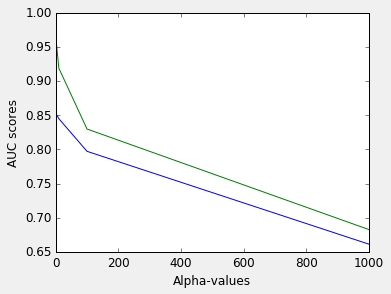

Best Alpha-CrossValidation: 1.0
Best Alpha-Tr data: 0.0001


In [0]:
a=[]
s =[]
for i,j in auc_scores_cv:
    a.append(j)
    s.append(i)
    
k =[]
l=[]

for i,j in auc_scores_tr:
    k.append(j)
    l.append(i)
    
plt.figure(figsize=(5,4))
plt.style.use('_classic_test')

plt.plot(a,s)
plt.plot(k,l)
#plt.xlim([-0.0001,1000])
plt.xlabel("Alpha-values")
plt.ylabel('AUC scores')
plt.show()

print("Best Alpha-CrossValidation:",max(auc_scores_cv)[1])
print("Best Alpha-Tr data:",max(auc_scores_tr)[1])

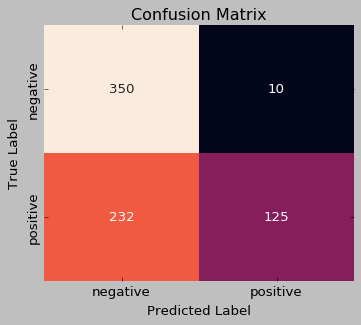

In [0]:
cm=confusion_matrix(y_cv,pred_cv)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(5,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### GridiSearchCv with BOW

In [0]:
hyper =[0.0001,0.001,0.01,0.1,1.0,10,100,1000]

In [0]:
param_grid=dict(alpha=hyper)
print(param_grid)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}


In [0]:
grid_mnb_bow = GridSearchCV(mnb_bow, param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=4)
grid_mnb_bow.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1000, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=4,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100,
                                   1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Estimators:",grid_mnb_bow.best_estimator_)
print("Best alpha:",grid_mnb_bow.best_params_)
print("Bset score:",grid_mnb_bow.best_score_)

Best Estimators: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Best alpha: {'alpha': 1.0}
Bset score: 0.8727678571428571


In [0]:
mnb_bow = MultinomialNB(grid_mnb_bow.best_params_['alpha'])
mnb_bow.fit(x_train,y_train)
y_pred_bow = mnb_bow.predict(x_test)
y_pred_train_bow = mnb_bow.predict(x_train)
print("Accuracy on Test Data:",accuracy_score(y_pred_bow,y_test)*100)
print("Accuracy on Train Data:",accuracy_score(y_pred_train_bow,y_train)*100)

Accuracy on Test Data: 85.28645833333334
Accuracy on Train Data: 95.56361607142857


**AUC SCore on Test Data**

In [0]:
fpr_test_bow, tpr_test_bow, thresholds = roc_curve(y_pred_bow, y_test)
auc_score_test_bow= auc(fpr_test_bow, tpr_test_bow)
print("AUC Score on Test data:",(auc_score_test_bow)*100)

AUC Score on Test data: 85.36575436572893


In [0]:
roc_auc_test_bow = roc_auc_score(y_test,y_pred_bow)
fpr_test,tpr_test,thersholds_test = roc_curve(y_test,mnb_bow.predict_proba(x_test)[:,1])

roc_auc_train_bow = roc_auc_score(y_train,y_pred_train_bow)
fpr_train,tpr_train,thersholds_train = roc_curve(y_train,mnb_bow.predict_proba(x_train)[:,1])


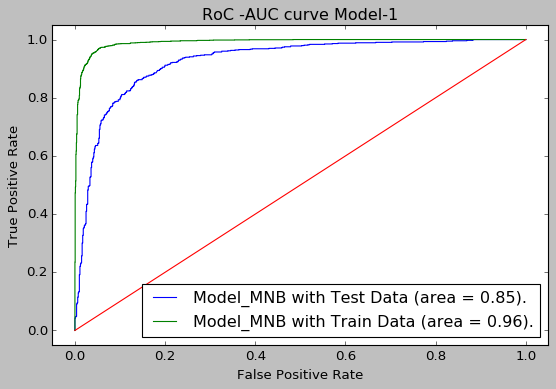

In [0]:
plt.figure(figsize=(8,5))
plt.style.use('classic')
plt.plot(fpr_test,tpr_test,label='Model_MNB with Test Data (area = %.2f).'% roc_auc_test_bow)
plt.plot(fpr_train,tpr_train,label='Model_MNB with Train Data (area = %.2f).'% roc_auc_train_bow)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-1")

plt.show()

#### Confusion Matrix _BOW - MNB

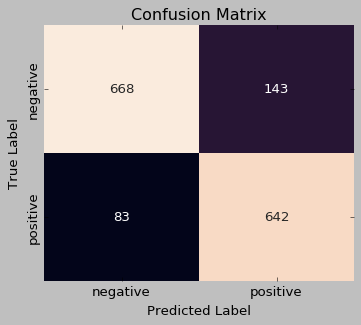

In [0]:
cm=confusion_matrix(y_test,y_pred_bow)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(5,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Feature Importace : BOW

In [0]:
# Reference : https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

top_negative = mnb_bow.feature_log_prob_[0, :].argsort()
top_positive = mnb_bow.feature_log_prob_[1, :].argsort()

print("Top 10 negative features: ",np.take(count_vect.get_feature_names(), top_negative[:10]))
print("Top 10 positive features: ",np.take(count_vect.get_feature_names(), top_positive[:10]))

Top 10 negative features:  ['aaaa' 'masa' 'marzipan' 'maryland' 'marvelously' 'marvelous' 'marvel'
 'maruchan' 'martini' 'martha']
Top 10 positive features:  ['mroe' 'expectant' 'expectancy' 'scoopfree' 'scorch' 'scorched'
 'lightand' 'exp' 'scotch' 'scott']


In [0]:
#x=preprocessed_reviews
#y=df['Score']

In [0]:
#x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=100)

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5)
tf_idf_words = tf_idf_vect.fit_transform(preprocessed_reviews)
#tf_idf_test = tf_idf_vect.fit_transform(x_test)

print("The shape of Tf-Idf:",tf_idf_words.get_shape())
print("Some of words in Tf-Idf words:",tf_idf_vect.get_feature_names()[:10])

#print("The shape of Tf-Idf-test:",tf_idf_test.get_shape())
#print("Some of words in Tf-Idf words:",tf_idf_vect.get_feature_names()[:10])

The shape of Tf-Idf: (5120, 7072)
Some of words in Tf-Idf words: ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able purchase', 'able use', 'absolute', 'absolute favorite']


In [0]:
x=tf_idf_words
print(type(x))
print(x.shape)
x = x.toarray()
print(x_train.shape)
print(type(x))

y =np.array(y).reshape(-1,1)
print(y.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(5120, 7072)
(3584, 5119)
<class 'numpy.ndarray'>
(5120, 1)


In [0]:
'''
x_test=tf_idf_test
print(type(x_test))
print(x_test.shape)
x_test = x_test.toarray()
print(x_test.shape)
print(type(x_test))


print(y_test.shape)'''

'\nx_test=tf_idf_test\nprint(type(x_test))\nprint(x_test.shape)\nx_test = x_test.toarray()\nprint(x_test.shape)\nprint(type(x_test))\n\n\nprint(y_test.shape)'

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1070)

In [0]:
#split train data into cross validation train and cross validation test
x_tr,x_cv,y_tr,y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=736)

auc_scores_cv=[]
auc_scores_tr = []

hyper =[0.0001,0.001,0.01,0.1,1.0,10,100,1000]

for i in hyper:
    mnb_tf = MultinomialNB(alpha=i)
    mnb_tf.fit(x_tr,y_tr)
    pred_cv= mnb_tf.predict(x_cv)
    pred_tr= mnb_tf.predict(x_tr)
     
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_cv, pred_cv)
    auc_score_cv = auc(fpr_cv, tpr_cv)
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, pred_tr)
    auc_score_tr = auc(fpr_tr, tpr_tr)
    
    
    auc_scores_cv.append((auc_score_cv,i))
    auc_scores_tr.append((auc_score_tr,i))
    
    print("\nCV Accuracy for Alpha (α)={} is {:.2f}".format(i,auc_score_cv))
    
print(10*'===')
print("Best accuracy:",max(auc_scores_cv))


CV Accuracy for Alpha (α)=0.0001 is 0.79

CV Accuracy for Alpha (α)=0.001 is 0.80

CV Accuracy for Alpha (α)=0.01 is 0.83

CV Accuracy for Alpha (α)=0.1 is 0.84

CV Accuracy for Alpha (α)=1.0 is 0.84

CV Accuracy for Alpha (α)=10 is 0.81

CV Accuracy for Alpha (α)=100 is 0.55

CV Accuracy for Alpha (α)=1000 is 0.50
Best accuracy: (0.8432957325148404, 1.0)


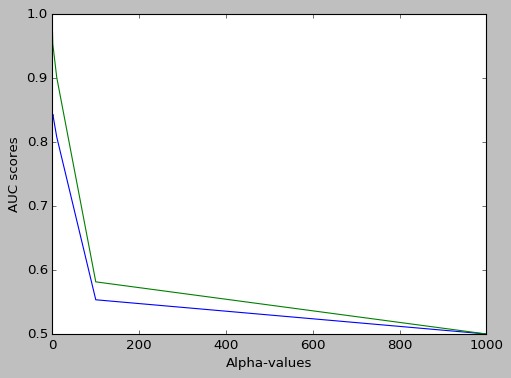

Best Alpha-CrossValidation: 1.0
Best Alpha-Tr data: 0.0001


In [0]:
a=[]
s =[]
for i,j in auc_scores_cv:
    a.append(j)
    s.append(i)
    
k =[]
l=[]

for i,j in auc_scores_tr:
    k.append(j)
    l.append(i)
    
plt.figure(figsize=(7,5))
plt.style.use('_classic_test')

plt.plot(a,s)
plt.plot(k,l)
#plt.xlim([-0.0001,1000])
plt.xlabel("Alpha-values")
plt.ylabel('AUC scores')
plt.show()

print("Best Alpha-CrossValidation:",max(auc_scores_cv)[1])
print("Best Alpha-Tr data:",max(auc_scores_tr)[1])

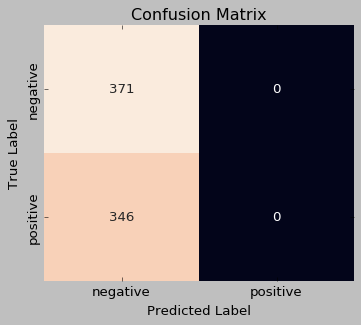

In [0]:
cm=confusion_matrix(y_cv,pred_cv)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(5,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
hyper =[0.0001,0.001,0.01,0.1,1.0,10,100,1000]
param_grid=dict(alpha=hyper)
print(param_grid)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}


In [0]:
grid_mnb_tf = GridSearchCV(mnb_tf, param_grid=param_grid,cv=3,scoring='accuracy',n_jobs=4)
grid_mnb_tf.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1000, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=4,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100,
                                   1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
print("Best Parameter:",grid_mnb_tf.best_estimator_)
print("Best Neighbors:",grid_mnb_tf.best_params_)
print("Bset score:",grid_mnb_tf.best_score_)

Best Parameter: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Best Neighbors: {'alpha': 1.0}
Bset score: 0.8727678571428571


In [0]:
mnb_tf = MultinomialNB(grid_mnb_tf.best_params_['alpha'])
mnb_tf.fit(x_train,y_train)
y_pred_tf = mnb_tf.predict(x_test)
y_pred_train_tf = mnb_tf.predict(x_train)

print("Accuracy on Test Data:",accuracy_score(y_pred_tf,y_test)*100)
print("Accuracy on Train Data:",accuracy_score(y_pred_train_tf,y_train)*100)

Accuracy on Test Data: 87.17447916666666
Accuracy on Train Data: 95.00558035714286


In [0]:
fpr_test_tf, tpr_test_tf, thresholds = roc_curve(y_pred_tf, y_test)
auc_score_test_tf= auc(fpr_test_tf, tpr_test_tf)
print("AUC Score on Test data:",(auc_score_test_tf)*100)

AUC Score on Test data: 87.25253195286908


In [0]:
roc_auc_test_tf = roc_auc_score(y_test,y_pred_tf)
fpr_test_tf,tpr_test_tf,thersholds_test_tf = roc_curve(y_test,mnb_tf.predict_proba(x_test)[:,1])

roc_auc_train_tf = roc_auc_score(y_train,y_pred_train_tf)
fpr_train,tpr_train,thersholds_train = roc_curve(y_train,mnb_tf.predict_proba(x_train)[:,1])


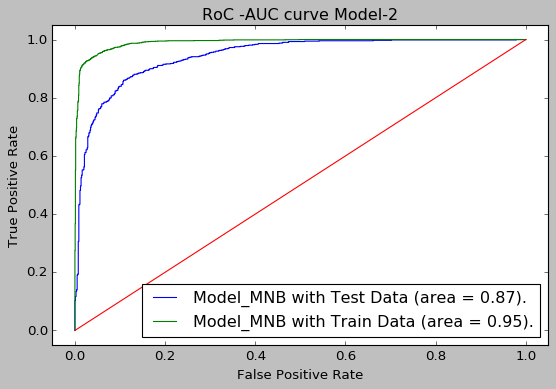

In [0]:
plt.figure(figsize=(8,5))
plt.style.use('classic')
plt.plot(fpr_test_tf,tpr_test_tf,label='Model_MNB with Test Data (area = %.2f).'% roc_auc_test_tf)
plt.plot(fpr_train,tpr_train,label='Model_MNB with Train Data (area = %.2f).'% roc_auc_train_tf)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Model-2")

plt.show()

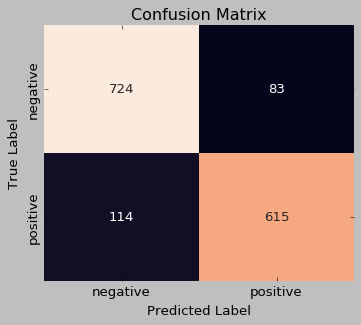

In [0]:
cm=confusion_matrix(y_test,y_pred_tf)

class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
plt.figure(figsize=(5,4))
sns.heatmap(df_cm, annot = True,cbar=False,fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Feature Importance: TF_IDF

In [0]:
# Reference : https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

top_negative = mnb_tf.feature_log_prob_[0, :].argsort()
top_positive = mnb_tf.feature_log_prob_[1, :].argsort()

print("Top 10 negative features: ",np.take(tf_idf_vect.get_feature_names(), top_negative[:10]))
print("Top 10 positive features: ",np.take(tf_idf_vect.get_feature_names(), top_positive[:10]))

Top 10 negative features:  ['zuke' 'not time' 'drawer' 'not resist' 'not particularly'
 'carbonated fruit' 'carbonated juice' 'not overpowering' 'not miss'
 'not long']
Top 10 positive features:  ['not send' 'extremely disappointed' 'made organic' 'detect' 'destroyed'
 'thinking might' 'make taste' 'makes wonder' 'nothing wrong' 'coarse']


##  Comparing the models tf-idf and Bow

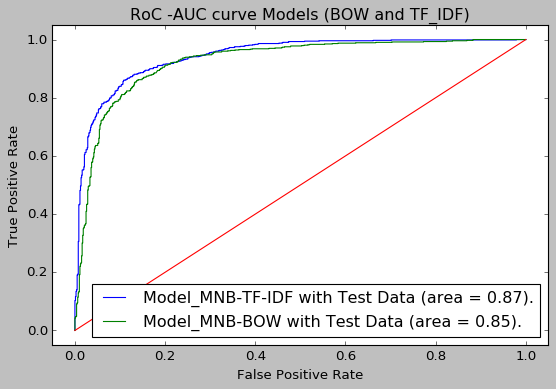

In [0]:
plt.figure(figsize=(8,5))
plt.style.use('classic')
plt.plot(fpr_test_tf,tpr_test_tf,label='Model_MNB-TF-IDF with Test Data (area = %.2f).'% roc_auc_test_tf)
plt.plot(fpr_test,tpr_test,label='Model_MNB-BOW with Test Data (area = %.2f).'% roc_auc_test_bow)
plt.plot([0,1],[0,1])
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc=0)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("RoC -AUC curve Models (BOW and TF_IDF)")

plt.show()

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = [ "Vectorizer","Hyper Parameter( α )", 'AUC']
x.add_row(["BOW",grid_mnb_bow.best_params_['alpha'] , np.round((auc_score_test_bow)*100,2)])
x.add_row(["TF-IDF", grid_mnb_tf.best_params_['alpha'],np.round((auc_score_test_tf)*100,2)])

print(x)

+------------+----------------------+-------+
| Vectorizer | Hyper Parameter( α ) |  AUC  |
+------------+----------------------+-------+
|    BOW     |         1.0          | 85.37 |
|   TF-IDF   |         1.0          | 87.25 |
+------------+----------------------+-------+
